In [1]:
import os
import sys

sys.path.append('../')

In [30]:
import torch
import numpy as np
import pytorch_lightning as pl

from tqdm.auto import tqdm
from pytorch_lightning.loggers import TensorBoardLogger

In [3]:
from benchmark.data import read_tep_data
from benchmark.deep_learning import TimeSeriesClassifier
from benchmark.deep_learning import FullyConvolutionalEncoder

## Reading the data

In [4]:
sources = [1, 3, 4, 5, 6]
target = [2,]

In [45]:
Xs, ys, ds = read_tep_data(
    base_path='../tep_data/benchmark/',
    modes=sources,
    normalization="standardization",
    return_domain=True,
    as_list=False,
    channels_first=True,
    one_hot_labels=False
)

In [46]:
Xs.shape, ys.shape, ds.shape

(torch.Size([14444, 34, 600]), torch.Size([14444]), torch.Size([14444]))

In [7]:
Xt, yt = read_tep_data(
    base_path='../tep_data/benchmark/',
    modes=target,
    normalization="standardization",
    return_domain=False,
    as_list=False,
    channels_first=True,
    one_hot_labels=False
)

In [8]:
Xt.shape, yt.shape

(torch.Size([2845, 34, 600]), torch.Size([2845]))

In [9]:
src_dataset = torch.utils.data.TensorDataset(Xs, ys)
src_dataloader = torch.utils.data.DataLoader(
    src_dataset, batch_size=256, shuffle=True)

tgt_dataset = torch.utils.data.TensorDataset(Xt, yt)
tgt_dataloader = torch.utils.data.DataLoader(
    tgt_dataset, batch_size=256, shuffle=True)

## Creating the neural net

In [14]:
encoder = FullyConvolutionalEncoder(
    n_features=Xs.shape[1],
    n_time_steps=Xs.shape[2],
    batch_norm=False,
    instance_norm=True
)

In [15]:
clf = torch.nn.Linear(128, 29)

In [16]:
n_epochs = 70
momentum = 0.9
l2_penalty = 0.0
learning_rate = 1e-4
optimizer_name = 'adam'

In [19]:
ckpt_path = '../models/logs/[1, 3, 4, 5, 6]->2/multi_source_only_baseline/version_0/checkpoints'
ckpt_filename = 'epoch=69-step=3990.ckpt'

In [20]:
model = TimeSeriesClassifier(
    encoder=encoder,
    clf=clf,
    n_classes=29,
    loss_fn=torch.nn.CrossEntropyLoss(),
    input_shape=(Xs.shape[1:]),
    learning_rate=learning_rate,
    l2_penalty=l2_penalty,
    momentum=momentum,
    optimizer_name=optimizer_name).load_from_checkpoint(
        os.path.join(ckpt_path, ckpt_filename),
        encoder=encoder,
        clf=clf,
        n_classes=29,
        loss_fn=torch.nn.CrossEntropyLoss(),
        input_shape=(Xs.shape[1:]),
        learning_rate=learning_rate,
        l2_penalty=l2_penalty,
        momentum=momentum,
    )

In [32]:
encoder = model.encoder.eval().cpu()
clf = model.clf.eval().cpu()

## Feature Extraction

In [24]:
dataset = {}

In [56]:
with torch.no_grad():
    for mode_k in sources:
        ind_k = np.where(ds == mode_k)[0]
        Xs_k = Xs[ind_k]
        ys_k = ys[ind_k]
        num_batches = int(np.ceil(len(Xs_k) / 256))
        Hs_k = []
        for k in tqdm(range(num_batches)):
            x = Xs_k[k * 256: (k + 1) * 256].float()
            Hs_k.append(encoder(x))
        Hs_k = torch.cat(Hs_k, axis=0)
        
        dataset['Mode {}'.format(mode_k)] = {"Features": Hs_k, "Labels": ys_k.float()}

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [61]:
with torch.no_grad():
    num_batches = int(np.ceil(len(Xt) / 256))
    Ht = []
    for k in tqdm(range(num_batches)):
        x = Xt[k * 256: (k + 1) * 256].float()
        Ht.append(encoder(x))
    Ht = torch.cat(Ht, axis=0)

    dataset['Mode {}'.format(target[0])] = {"Features": Ht, "Labels": yt.float()}

  0%|          | 0/12 [00:00<?, ?it/s]

In [63]:
all_X = torch.cat([dataset[f'Mode {mode}']['Features'] for mode in range(1, 7)])
all_y = torch.cat([dataset[f'Mode {mode}']['Labels'] for mode in range(1, 7)])
all_d = torch.cat([
    torch.tensor([mode] * len(dataset[f'Mode {mode}']['Features'])) for mode in range(1, 7)])

In [64]:
all_X.shape, all_y.shape, all_d.shape

(torch.Size([17289, 128]), torch.Size([17289]), torch.Size([17289]))

In [126]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

In [97]:
def scatter_letters(X, y, ax=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(5, 5))
        
    for i in range(len(X)):
        ax.text(x=X[i, 0],
                y=X[i, 1],
                s=f"{int(y[i])}", **kwargs)
        
    return ax

In [66]:
embeddings = TSNE(n_components=2).fit_transform(all_X)

/home/efernand/anaconda3/envs/OptimalTransport/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/efernand/anaconda3/envs/OptimalTransport/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


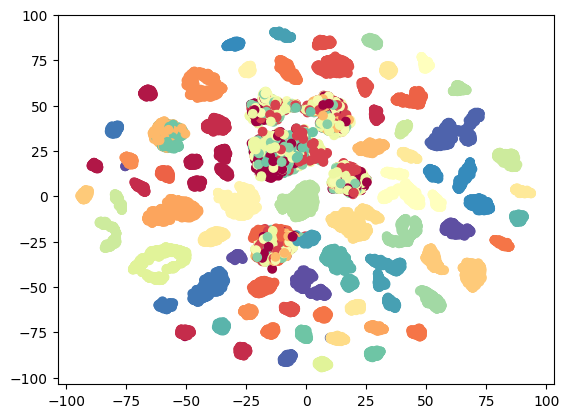

In [68]:
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=all_y, cmap='Spectral')

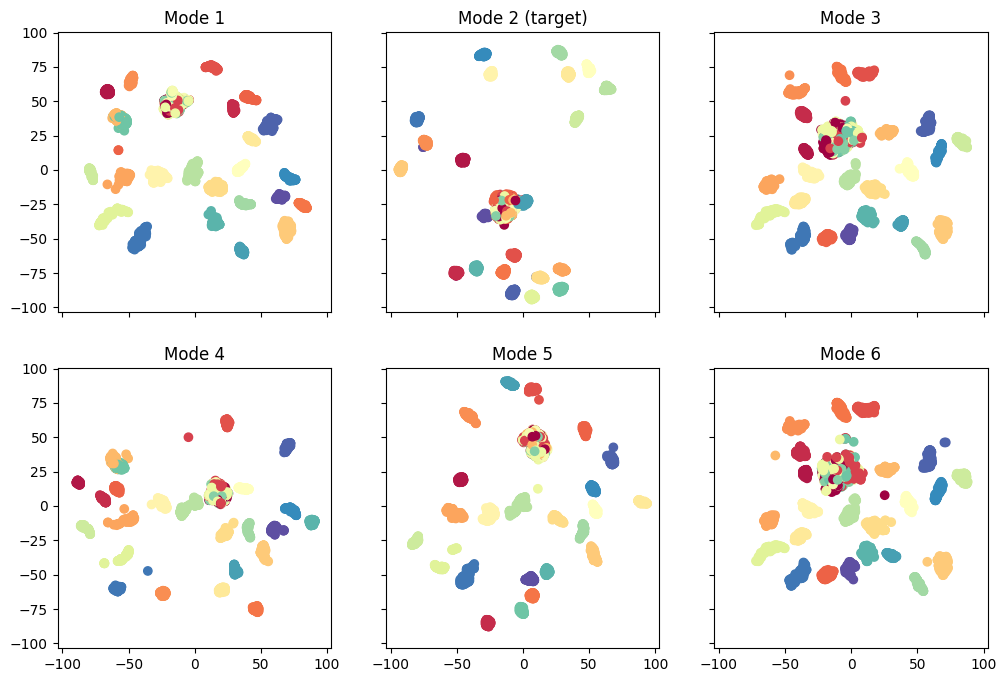

In [119]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

for source in sources:
    ind = np.where(all_d == source)[0]
    axes.flatten()[source - 1].set_title(f"Mode {source}")
    axes.flatten()[source - 1].scatter(embeddings[ind, 0],
                                       embeddings[ind, 1],
                                       c=all_y[ind], cmap='Spectral')
ind = np.where(all_d == target[0])[0]
axes.flatten()[target[0] - 1].set_title(f"Mode {target[0]} (target)")
axes.flatten()[target[0] - 1].scatter(embeddings[ind, 0],
                                   embeddings[ind, 1],
                                   c=all_y[ind], cmap='Spectral')

<AxesSubplot: title={'center': 'Mode 2 (target)'}>

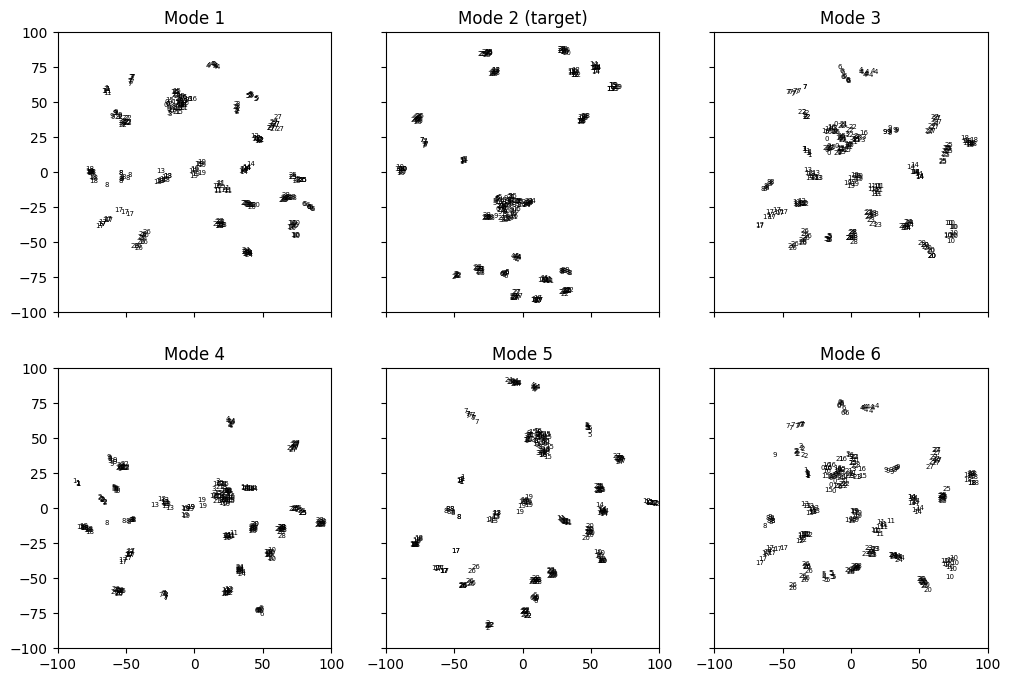

In [135]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

for ax in axes.flatten():
    ax.set_xlim([-100, 100])
    ax.set_ylim([-100, 100])

for source in sources:
    ind = np.where(all_d == source)[0]
    ind, _ = train_test_split(ind, train_size=0.1, stratify=all_y[ind])
    axes.flatten()[source - 1].set_title(f"Mode {source}")
    scatter_letters(embeddings[ind], all_y[ind], ax=axes.flatten()[source - 1], fontsize=5)
ind = np.where(all_d == target[0])[0]
ind, _ = train_test_split(ind, train_size=0.1, stratify=all_y[ind])
axes.flatten()[target[0] - 1].set_title(f"Mode {target[0]} (target)")
scatter_letters(embeddings[ind], all_y[ind], ax=axes.flatten()[target[0] - 1], fontsize=5)